# Imports

In [172]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import screed
from sklearn import metrics

%matplotlib inline

In [122]:
def describe(df):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    print('--- Random subset ---')
    display(df.sample(5))

# Get gold standard reading frames

## Read gold standard reading frame file

In [179]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame
true_coding_frame.head()

,is_coding
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2,False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3,False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1,False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2,False


# Read concatenated scores for metrics

## Human

In [89]:
%%time


has_stop_codon = 'Translation frame has stop codon(s)'


parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet'
human_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
human_scores_for_metrics = human_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')

# human_scores_for_metrics = human_scores_for_metrics.set_index('read_id_frame')
print(human_scores_for_metrics.shape)
human_scores_for_metrics.head()

(43973736, 12)
CPU times: user 1min 59s, sys: 1min 2s, total: 3min 1s
Wall time: 1min 33s


### Make sure none of the jaccard in peptide db is null

In [90]:
human_scores_for_metrics.jaccard_in_peptide_db.isnull().sum()

0

In [91]:
human_scores_for_metrics.category.value_counts()

Non-coding    30860350
Coding        13113386
Name: category, dtype: int64

In [92]:
# human_scores_for_metrics.loc[human_scores_for_metrics.jaccard_in_peptide_db.isnull()]

In [79]:
! ls -lha $parquet

-rw-r--r-- 1 olga czb 1018M Sep 30 17:24 /mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet


In [80]:
human_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.888889,36.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,14,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.846154,26.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,24,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.875000,32.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,18,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.789474,19.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.840000,25.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,25,human,False,sp|O43295|ENSP00000373347,O43295


## Mouse (remove stop codon in first step)

In [93]:
%%time

parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'
mouse_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
# mouse_scores_for_metrics = mouse_scores_for_metrics.set_index('read_id_frame')
mouse_scores_for_metrics = mouse_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')
print(mouse_scores_for_metrics.shape)
mouse_scores_for_metrics.head()

(43973736, 12)
CPU times: user 1min 43s, sys: 1min 7s, total: 2min 50s
Wall time: 1min 22s


### Make sure none of the jaccard in peptide db is null

In [94]:
mouse_scores_for_metrics.jaccard_in_peptide_db.isnull().sum()

0

In [67]:
mouse_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read6001/sp|A0A087WTH1|ENSP00000477871;mate1:91-240;mate2:164-313__frame=1,read6001/sp|A0A087WTH1|ENSP00000477871;mate1:9...,1.0,29.0,Coding,1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,22,human,True,sp|A0A087WTH1|ENSP00000477871,A0A087WTH1
read6001/sp|A0A087WTH1|ENSP00000477871;mate1:91-240;mate2:164-313__frame=2,read6001/sp|A0A087WTH1|ENSP00000477871;mate1:9...,0.0,28.0,Non-coding,2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,22,human,False,sp|A0A087WTH1|ENSP00000477871,A0A087WTH1
read6001/sp|A0A087WTH1|ENSP00000477871;mate1:91-240;mate2:164-313__frame=-1,read6001/sp|A0A087WTH1|ENSP00000477871;mate1:9...,0.0,29.0,Non-coding,-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,22,human,False,sp|A0A087WTH1|ENSP00000477871,A0A087WTH1
read6001/sp|A0A087WTH1|ENSP00000477871;mate1:91-240;mate2:164-313__frame=-2,read6001/sp|A0A087WTH1|ENSP00000477871;mate1:9...,0.0,28.0,Non-coding,-2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,22,human,False,sp|A0A087WTH1|ENSP00000477871,A0A087WTH1
read6002/sp|A0A087WTH1|ENSP00000477871;mate1:12-161;mate2:81-230__frame=1,read6002/sp|A0A087WTH1|ENSP00000477871;mate1:1...,0.0,29.0,Non-coding,1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,22,human,False,sp|A0A087WTH1|ENSP00000477871,A0A087WTH1


## Combine mouse and human to compute scores on one

In [109]:
combined_scores = pd.concat([human_scores_for_metrics, mouse_scores_for_metrics])
combined_scores = combined_scores.sort_index()
print(combined_scores.shape)
combined_scores.head()

(87947472, 12)


,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.888889,36.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,14,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,27.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,23,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,35.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,15,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,37.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,31.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,mouse,False,sp|O43295|ENSP00000373347,O43295


# Compute accuracy/F1 scores

## Human F1 scores

In [95]:
%%time

score_names = 'accuracy', 'f1', 'jaccard', 'precision', 'recall',  


metrics = {
    'f1_score': sklearn.metrics.f1_score,
    'accuracy_score': sklearn.metrics.accuracy_score,
    'jaccard_score': sklearn.metrics.jaccard_score,
    'precision_score': sklearn.metrics.precision_score,
    'recall_score': sklearn.metrics.recall_score,
}

def score_coding_metrics(coding_results, true_coding_frame=true_coding_frame, metrics=metrics):

    dfs = []
    for score_name, scorer in tqdm(metrics.items()):
        print(f'score_name: {score_name}')
    #     scorer = sklearn.metrics.get_scorer(score_name)

        scores = coding_results.groupby(['alphabet', 'ksize']).is_coding.apply(
            lambda x: scorer(true_coding_frame[x.index], x))

        scores.name = 'score_value'
        scores_df = scores.reset_index()
        scores_df['score_name'] = score_name
        dfs.append(scores_df)
    metrics_df = pd.concat(dfs)
    return metrics_df

human_metrics = score_coding_metrics(human_scores_for_metrics_no_stops)
print(human_metrics.shape)
human_metrics.head()

  0%|          | 0/5 [00:00<?, ?it/s]

score_name: f1_score


 20%|██        | 1/5 [01:29<05:56, 89.11s/it]

score_name: accuracy_score


 40%|████      | 2/5 [02:47<04:10, 83.52s/it]

score_name: jaccard_score


 60%|██████    | 3/5 [04:19<02:52, 86.39s/it]

score_name: precision_score


 80%|████████  | 4/5 [05:48<01:27, 87.25s/it]

score_name: recall_score


100%|██████████| 5/5 [07:16<00:00, 87.20s/it]

(230, 4)
CPU times: user 7min, sys: 15.6 s, total: 7min 15s
Wall time: 7min 16s


In [96]:
human_metrics.head()

,alphabet,ksize,score_value,score_name
0,dayhoff,9,0.731461,f1_score
1,dayhoff,10,0.799807,f1_score
2,dayhoff,11,0.803127,f1_score
3,dayhoff,12,0.798396,f1_score
4,dayhoff,13,0.796747,f1_score


### Write human metrics to csv!!!

In [97]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores_metrics.csv'
human_metrics.to_csv(csv, index=False)

### Plot metrics

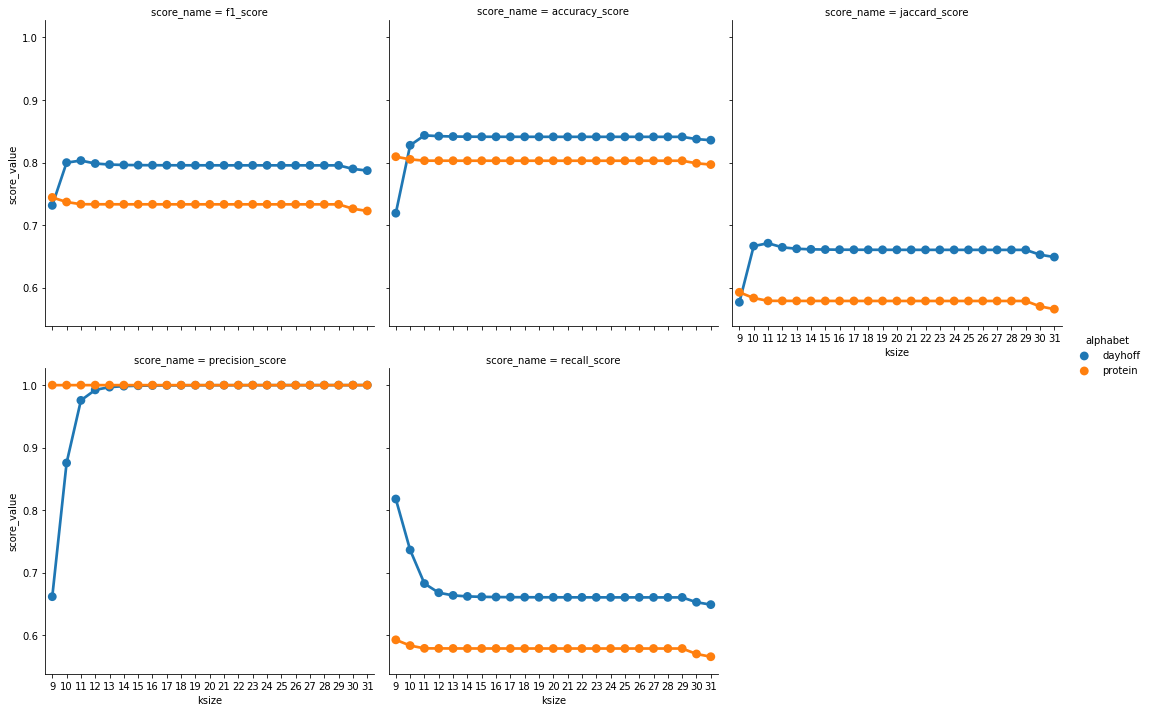

In [98]:
sns.catplot(x='ksize', y='score_value', hue='alphabet', col='score_name', 
            data=human_metrics, kind='point', col_wrap=3)

## Compute mouse metrics

In [99]:
mouse_metrics = score_coding_metrics(mouse_scores_for_metrics)
print(mouse_metrics.shape)
mouse_metrics.head()

  0%|          | 0/5 [00:00<?, ?it/s]

score_name: f1_score


 20%|██        | 1/5 [01:34<06:16, 94.02s/it]

score_name: accuracy_score


 40%|████      | 2/5 [02:38<03:57, 79.04s/it]

score_name: jaccard_score


 60%|██████    | 3/5 [03:57<02:38, 79.23s/it]

score_name: precision_score


 80%|████████  | 4/5 [05:14<01:18, 78.55s/it]

score_name: recall_score


100%|██████████| 5/5 [06:29<00:00, 77.93s/it]


(230, 4)


,alphabet,ksize,score_value,score_name
0,dayhoff,9,0.580812,f1_score
1,dayhoff,10,0.436512,f1_score
2,dayhoff,11,0.333732,f1_score
3,dayhoff,12,0.304096,f1_score
4,dayhoff,13,0.293682,f1_score


### Write mouse metrics to csv!!!

In [100]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores_metrics.csv'
mouse_metrics.to_csv(csv, index=False)

### Plot metrics

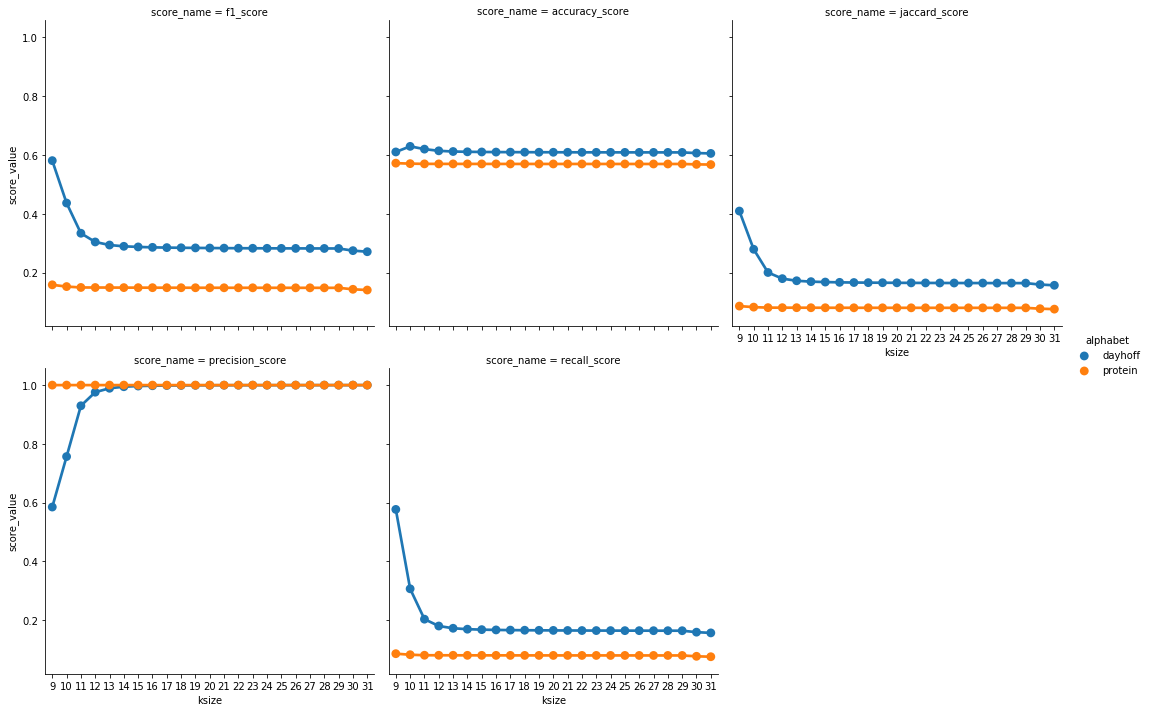

In [101]:
sns.catplot(x='ksize', y='score_value', hue='alphabet', col='score_name', 
            data=mouse_metrics, kind='point', col_wrap=3)

## Look at metric differences

In [102]:
index_cols = ['alphabet', 'ksize', 'score_name']
mouse_metrics_index = mouse_metrics.set_index(index_cols)
human_metrics_index = human_metrics.set_index(index_cols)

In [103]:
human_metrics_index.head()

score_value
alphabet ksize score_name             
dayhoff  9     f1_score       0.731461
         10    f1_score       0.799807
         11    f1_score       0.803127
         12    f1_score       0.798396
         13    f1_score       0.796747

In [104]:
human_minus_mouse = human_metrics_index.score_value - mouse_metrics_index.score_value
human_minus_mouse = human_minus_mouse.reset_index()
human_minus_mouse.head()

,alphabet,ksize,score_name,score_value
0,dayhoff,9,f1_score,0.150649
1,dayhoff,10,f1_score,0.363295
2,dayhoff,11,f1_score,0.469395
3,dayhoff,12,f1_score,0.494300
4,dayhoff,13,f1_score,0.503064


In [110]:
human_minus_mouse.query('score_value != 0')

,alphabet,ksize,score_name,score_value
0,dayhoff,9,f1_score,0.150649
1,dayhoff,10,f1_score,0.363295
2,dayhoff,11,f1_score,0.469395
3,dayhoff,12,f1_score,0.494300
4,dayhoff,13,f1_score,0.503064
5,dayhoff,14,f1_score,0.506744
6,dayhoff,15,f1_score,0.508611
7,dayhoff,16,f1_score,0.509863
8,dayhoff,17,f1_score,0.510705
9,dayhoff,18,f1_score,0.511239


## Compute ROC AUC

### Human

In [143]:
%%time

def compute_roc_auc(coding_results, true_coding_frame=true_coding_frame):
    scores = coding_results.groupby(['alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: sklearn.metrics.roc_auc_score(true_coding_frame[x.index], x))

    scores.name = 'score_value'
    scores_df = scores.reset_index()
    scores_df['score_name'] = 'roc_auc'

    return scores_df

human_roc_auc_score = compute_roc_auc(human_scores_for_metrics)
human_roc_auc_score.head()

,alphabet,ksize,score_value,score_name
0,dayhoff,9,0.783296,roc_auc
1,dayhoff,10,0.895445,roc_auc
2,dayhoff,11,0.958837,roc_auc
3,dayhoff,12,0.981756,roc_auc
4,dayhoff,13,0.989993,roc_auc


### Mouse

In [144]:
%%time

mouse_roc_auc_score = compute_roc_auc(mouse_scores_for_metrics)
mouse_roc_auc_score.head()

,alphabet,ksize,score_value,score_name
0,dayhoff,9,0.641264,roc_auc
1,dayhoff,10,0.690050,roc_auc
2,dayhoff,11,0.739790,roc_auc
3,dayhoff,12,0.780828,roc_auc
4,dayhoff,13,0.809111,roc_auc



## Compute ROC Curve

### Human

In [163]:
%%time

def _get_roc_curve_df(y_true, y_score):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df.index.name = 'threshold_i'
    return df



def compute_roc_curve(coding_results, true_coding_frame=true_coding_frame):
    curve_df = coding_results.groupby(['alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: _get_roc_curve_df(true_coding_frame[x.index], x))

    curve_df['score_name'] = 'roc_auc'

    return curve_df

human_roc_curve = compute_roc_curve(human_scores_for_metrics)
describe(human_roc_curve)

(8788, 4)
--- First 5 entries ---


fpr       tpr  thresholds score_name
alphabet ksize threshold_i                                           
dayhoff  9     0            0.000000  0.000000     2.00000    roc_auc
               1            0.218426  0.764102     1.00000    roc_auc
               2            0.243622  0.774810     0.97619    roc_auc
               3            0.297313  0.795568     0.97561    roc_auc
               4            0.299702  0.795763     0.97500    roc_auc

--- Random subset ---


fpr       tpr  thresholds score_name
alphabet ksize threshold_i                                           
dayhoff  11    43           0.029902  0.719403    0.913043    roc_auc
         31    17           0.000214  0.707424    0.736842    roc_auc
         19    237          0.025537  0.990640    0.066667    roc_auc
         16    4            0.000448  0.661132    0.969697    roc_auc
protein  10    214          0.000639  0.997090    0.270270    roc_auc

CPU times: user 1min 1s, sys: 6.95 s, total: 1min 8s
Wall time: 1min 8s


### Mouse

In [164]:
%%time

mouse_roc_curve = compute_roc_curve(mouse_scores_for_metrics)
describe(mouse_roc_curve)

(9206, 4)
--- First 5 entries ---


fpr       tpr  thresholds score_name
alphabet ksize threshold_i                                           
dayhoff  9     0            0.000000  0.000000     2.00000    roc_auc
               1            0.212594  0.421569     1.00000    roc_auc
               2            0.237326  0.450532     0.97619    roc_auc
               3            0.290313  0.508084     0.97561    roc_auc
               4            0.292696  0.508722     0.97500    roc_auc

--- Random subset ---


fpr       tpr  thresholds score_name
alphabet ksize threshold_i                                           
dayhoff  16    335          0.093705  0.692926    0.066667    roc_auc
         20    54           0.000322  0.216335    0.750000    roc_auc
         10    171          0.517764  0.763035    0.681818    roc_auc
         15    246          0.027673  0.513006    0.352941    roc_auc
         9     57           0.484109  0.679910    0.894737    roc_auc

CPU times: user 1min 22s, sys: 2.23 s, total: 1min 24s
Wall time: 1min 24s


# Combine metrics

## Combine non-curve sscores

In [145]:
mouse_metrics['species'] = 'mouse'
human_metrics['species'] = 'human'
mouse_roc_auc_score['species'] = 'mouse'
human_roc_auc_score['species'] = 'human'

In [150]:
combined_metrics = pd.concat([human_metrics, human_roc_auc_score, mouse_metrics, mouse_roc_auc_score], ignore_index=True)
describe(combined_metrics)

(552, 5)
--- First 5 entries ---


,alphabet,ksize,score_value,score_name,species
0,dayhoff,9,0.731461,f1_score,human
1,dayhoff,10,0.799807,f1_score,human
2,dayhoff,11,0.803127,f1_score,human
3,dayhoff,12,0.798396,f1_score,human
4,dayhoff,13,0.796747,f1_score,human


--- Random subset ---


,alphabet,ksize,score_value,score_name,species
51,dayhoff,14,0.841269,accuracy_score,human
436,dayhoff,31,0.999672,precision_score,mouse
462,dayhoff,11,0.203384,recall_score,mouse
26,protein,12,0.733262,f1_score,human
542,protein,22,0.689525,roc_auc,mouse


In [151]:
combined_metrics.score_name.value_counts()

jaccard_score      92
roc_auc            92
recall_score       92
f1_score           92
precision_score    92
accuracy_score     92
Name: score_name, dtype: int64

## Plot combined metrics

### Groupby score name, one by one

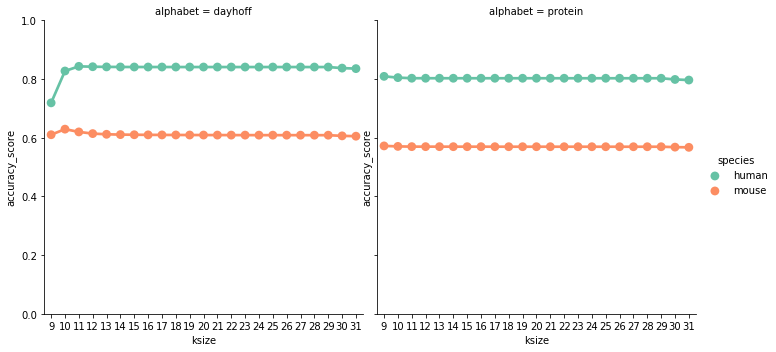

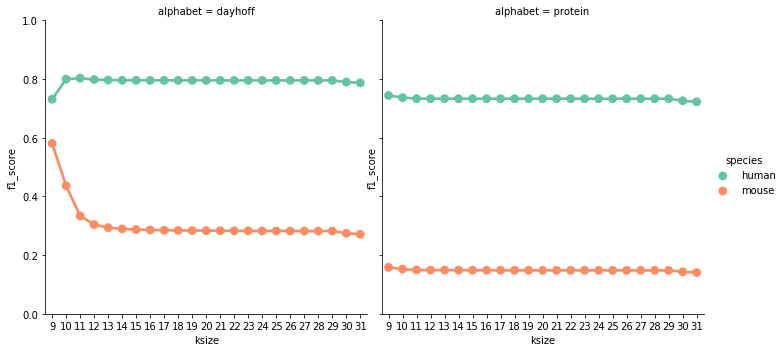

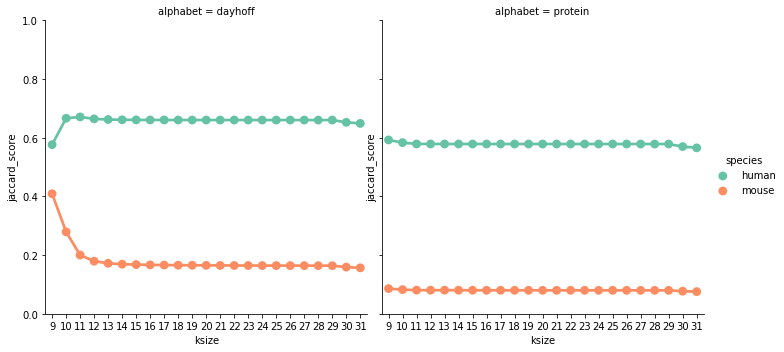

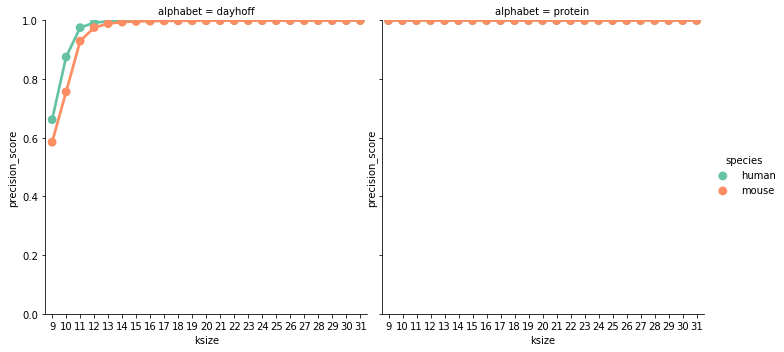

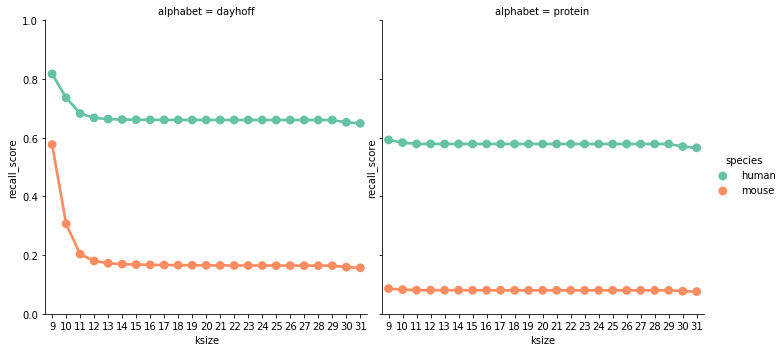

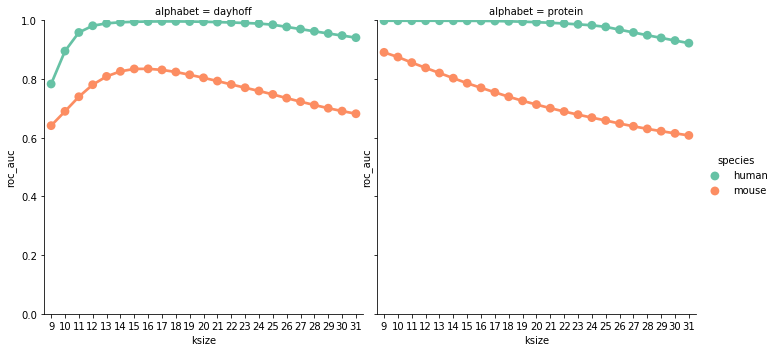

In [152]:
for score_name, df in combined_metrics.groupby('score_name'):
    g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
            data=df, kind='point', palette="Set2")
    g.set(ylabel=score_name, ylim=(0, 1))

## Just plot ROC AUC

In [185]:
combined_roc_auc = combined_metrics.query('score_name == "roc_auc"')

In [186]:
combined_roc_auc.loc[combined_roc_auc.groupby(['species', 'score_name', 'alphabet']).score_value.idxmax()]

,alphabet,ksize,score_value,score_name,species
238,dayhoff,17,0.996602,roc_auc,human
255,protein,11,0.998840,roc_auc,human
513,dayhoff,16,0.834927,roc_auc,mouse
529,protein,9,0.891089,roc_auc,mouse


args: ()
kwargs: {'color': (0.4, 0.7607843137254902, 0.6470588235294118), 'label': 'human'}
args: ()
kwargs: {'color': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'label': 'mouse'}
args: ()
kwargs: {'color': (0.4, 0.7607843137254902, 0.6470588235294118), 'label': 'human'}
args: ()
kwargs: {'color': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'label': 'mouse'}


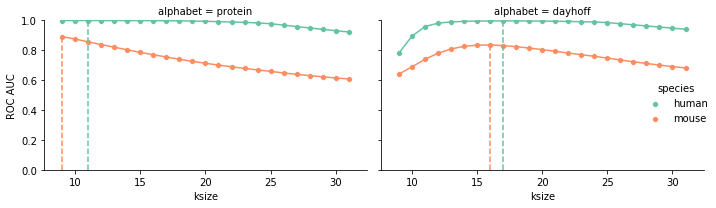

In [203]:
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    plt.vlines(x[idxmax], 0, y.max(), linestyle='--', *args, **kwargs)
#     print('x:', x)
#     print('y:', y)
    print('args:', args)
    print('kwargs:', kwargs)
    pass

alphabet_order = ['protein', 'dayhoff']
g = sns.FacetGrid( hue='species', col='alphabet', col_order=alphabet_order,
        data=combined_roc_auc, palette="Set2", height=3, aspect=1.5)
g.map(sns.scatterplot, 'ksize', 'score_value')
g.add_legend()
g.map(plt.plot, 'ksize', 'score_value')
g.map(plot_argmax, 'ksize', 'score_value')
g.set(ylabel='ROC AUC', ylim=(0, 1))


### All in one grid

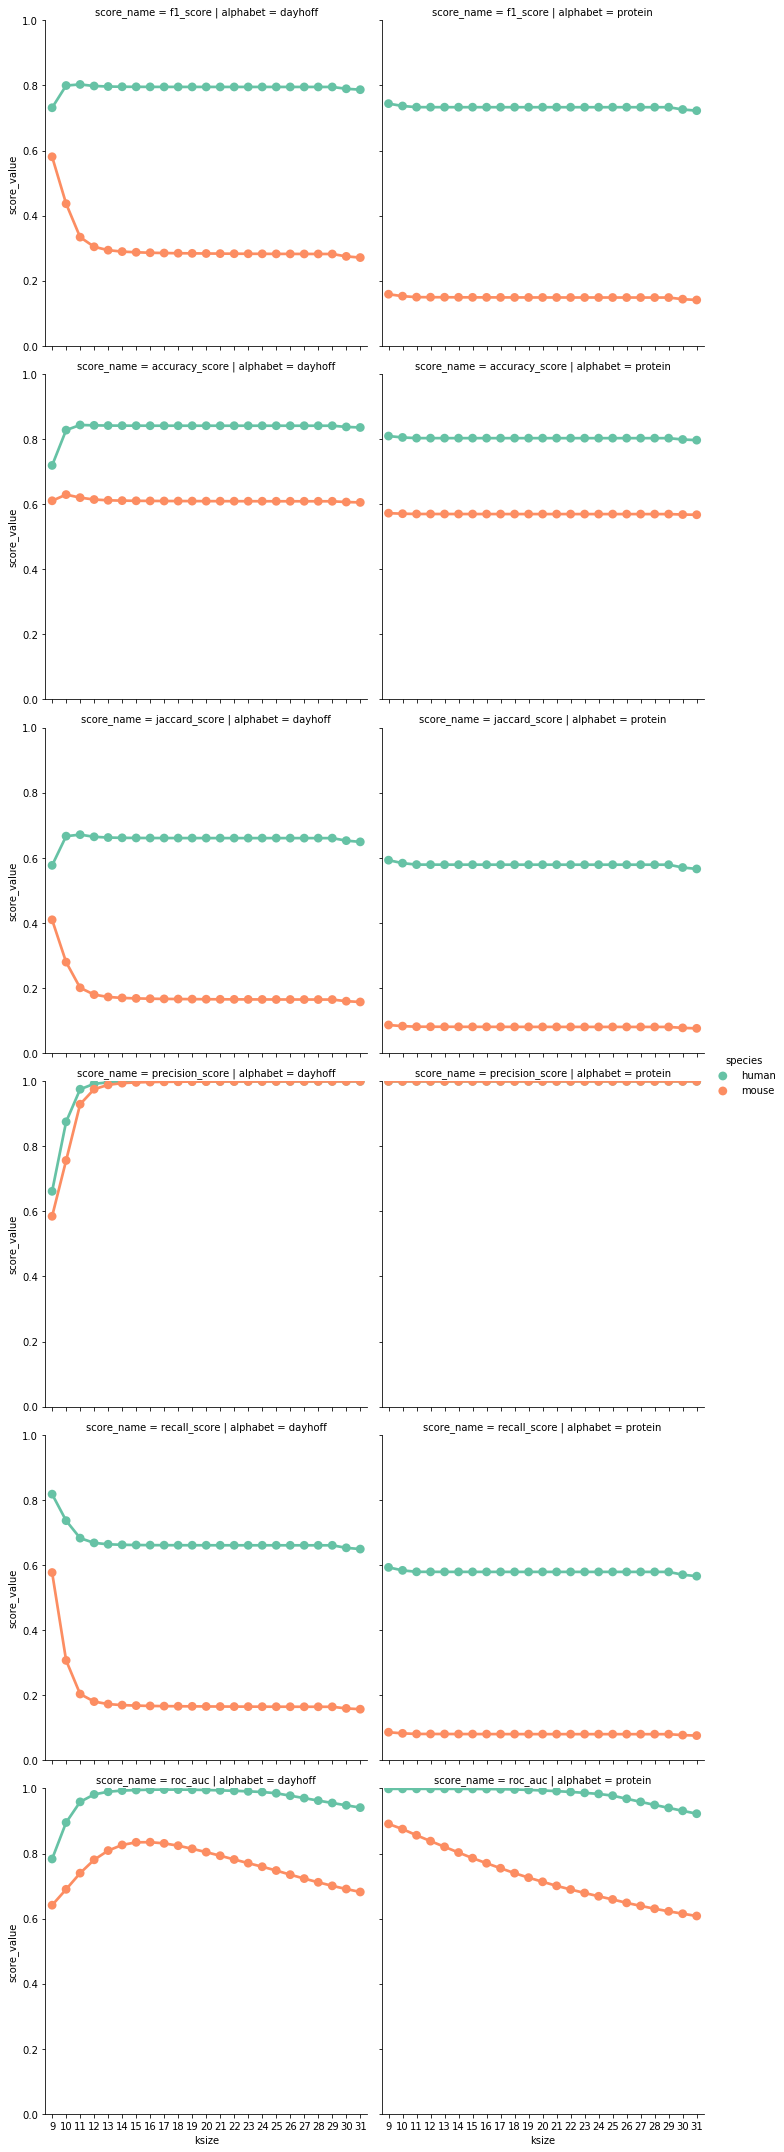

In [153]:
g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
        data=combined_metrics, kind='point', palette='Set2', row='score_name')
g.set(ylim=(0, 1 ))

## Combine roc curves

In [165]:
human_roc_curve['species'] = 'human'
mouse_roc_curve['species'] = 'mouse'

In [ ]:
human_roc_curve

In [167]:
combined_roc_curves = pd.concat([human_roc_curve.reset_index(), mouse_roc_curve.reset_index()])
describe(combined_roc_curves)

(17994, 8)
--- First 5 entries ---


,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,species
0,dayhoff,9,0,0.000000,0.000000,2.00000,roc_auc,human
1,dayhoff,9,1,0.218426,0.764102,1.00000,roc_auc,human
2,dayhoff,9,2,0.243622,0.774810,0.97619,roc_auc,human
3,dayhoff,9,3,0.297313,0.795568,0.97561,roc_auc,human
4,dayhoff,9,4,0.299702,0.795763,0.97500,roc_auc,human


--- Random subset ---


,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,species
7010,protein,11,277,0.001978,0.624067,0.078947,roc_auc,mouse
1260,dayhoff,11,377,0.808511,0.936863,0.217391,roc_auc,mouse
3794,dayhoff,18,169,0.005753,0.960017,0.388889,roc_auc,human
2287,dayhoff,14,10,0.000838,0.169230,0.965517,roc_auc,mouse
4254,dayhoff,19,211,0.009644,0.514561,0.218750,roc_auc,mouse


### Plot individual roc curve

In [169]:
human_roc_curve_reset = human_roc_curve.reset_index()

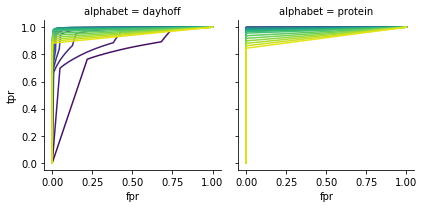

In [173]:
g = sns.FacetGrid(data=human_roc_curve_reset, col='alphabet', hue='ksize', palette='viridis')
g.map(plt.plot, 'fpr', 'tpr')

### Plot combined roc curves

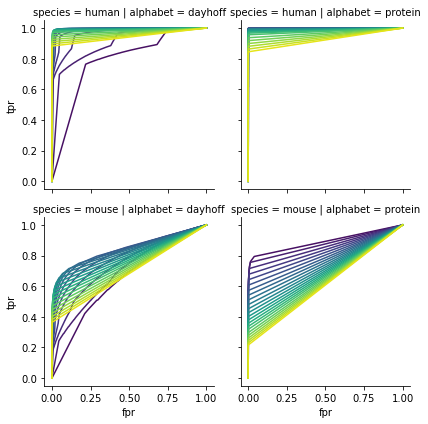

In [174]:

g = sns.FacetGrid(data=combined_roc_curves, col='alphabet', hue='ksize', palette='viridis', row='species')
g.map(plt.plot, 'fpr', 'tpr')